In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block
from bold_dementia.utils.iterables import unique

ATLAS = "schaeffer200"
SOFT = False
ALPHA = config["alpha"]
atlas = Atlas.from_name(ATLAS, soft=SOFT)
labels = tuple(sorted(unique(atlas.macro_labels)))

In [2]:
expname = f"atlas-{ATLAS}_synthetic_ols-cenanom-block"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)

resdf = pd.read_csv(matrices_path / "resdf.csv", index_col=0)
resdf["node_a"] = resdf["edges"].map(lambda edge: edge.split("_")[0])
resdf["node_b"] = resdf["edges"].map(lambda edge: edge.split("_")[1])

mask = np.where(resdf["pvalues_fdr"] < ALPHA, 1, 0) 
resdf["thresholded_beta"] = resdf["beta_AD"] * mask

resdf = resdf.drop("edges", axis=1)

resdf_pv = resdf.pivot(index="node_a" ,columns=["node_b"], values=["beta_AD", "pvalues_raw", "pvalues_fdr", "thresholded_beta"])

In [3]:
resdf_pv.loc[:, "beta_AD"]

node_b,Cont,Default,DorsAttn,Limbic,SalVentAttn,SomMot,Vis
node_a,,,,,,,
Cont,-0.000376,0.000901,0.000404,-0.000029,-0.000516,0.001370,0.000230
Default,0.000901,-0.033575,0.000164,-0.000315,0.000573,0.001529,0.000618
DorsAttn,0.000404,0.000164,0.001285,-0.000492,-0.000450,0.000834,-0.000259
Limbic,-0.000029,-0.000315,-0.000492,-0.000970,0.000176,-0.001978,-0.000026
SalVentAttn,-0.000516,0.000573,-0.000450,0.000176,-0.000567,-0.000480,0.000342
SomMot,0.001370,0.001529,0.000834,-0.001978,-0.000480,-0.035422,0.000358
Vis,0.000230,0.000618,-0.000259,-0.000026,0.000342,0.000358,-0.000052


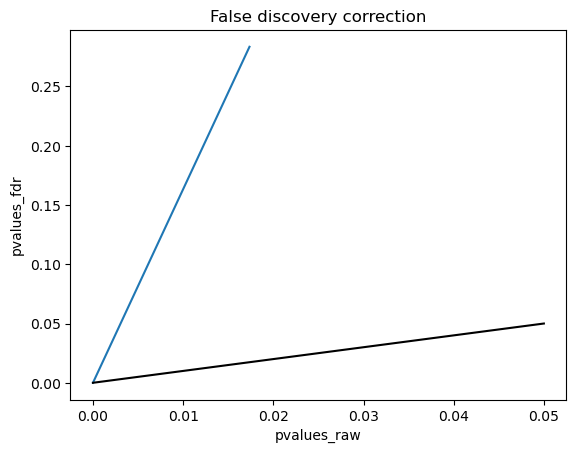

In [4]:
sns.lineplot(resdf[resdf.pvalues_raw < ALPHA], x="pvalues_raw", y="pvalues_fdr")
x = np.linspace(0, ALPHA, 100)
plt.plot(x, x, color="black")
plt.title(f"False discovery correction")
plt.show()

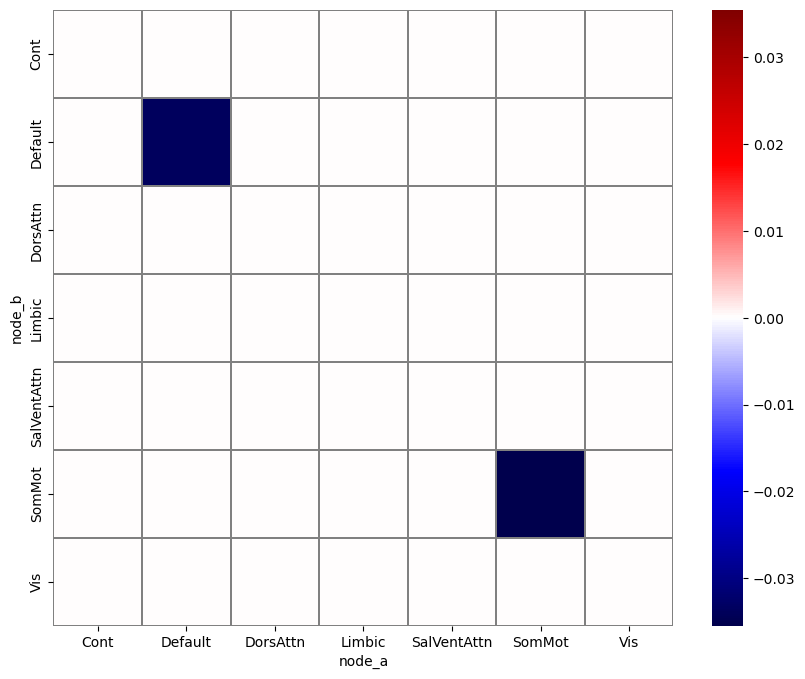

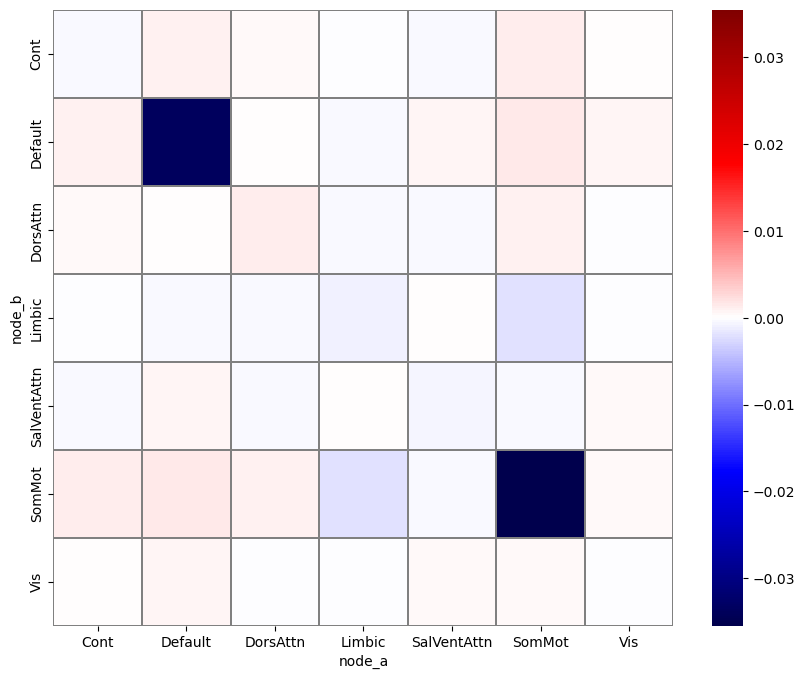

In [5]:
span = max(
    resdf["thresholded_beta"].min().__abs__(),
    resdf["thresholded_beta"].max().__abs__()
)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    resdf_pv.loc[:, "thresholded_beta"].T,
    vmin=-span, vmax=span, cmap="seismic", linewidths=0.1, linecolor="gray"
)

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    resdf_pv.loc[:, "beta_AD"].T,
    vmin=-span, vmax=span, cmap="seismic", linewidths=0.1, linecolor="gray"
)
plt.show()